# Imports

In [35]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pycaret.regression import RegressionExperiment
import data_func.read_data as read_data



# Load datasets

In [36]:
dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()


In [37]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]

## Cleaning X

Found a hole in the X data on location A

1|2
---|---
![1](./feature_cleaning/img/X_A_1.png) | ![2](./feature_cleaning/img/X_A_2.png)

This prevents our aggregation method to match the target data after these data points

Trying to remove this point and reindex to fix the issue. 

In [38]:
print("A: \n", len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 00:00:00'))].index
print(ind)
XTRA = XTRA.drop(ind).reset_index(drop=True)
print(len(XTRA))

A: 
 136245
Int64Index([118664], dtype='int64')
136244


Same problem for B-set at `2022-05-02 23:00:00` and C-set at `2022-04-25 21:00:00`

In [39]:
print("B: \n", len(XTRB))
ind = XTRB[(XTRB['date_forecast'] == pd.to_datetime('2022-05-02 21:00:00'))].index
print(ind)
XTRB = XTRB.drop(ind).reset_index(drop=True)
print(len(XTRB))

print("C: \n",len(XTRC))
ind = XTRC[(XTRC['date_forecast'] == pd.to_datetime('2022-04-25 21:00:00'))].index
print(ind)
XTRC = XTRC.drop(ind).reset_index(drop=True)
print(len(XTRC))

B: 
 134505
Int64Index([116916], dtype='int64')
134504
C: 
 134401
Int64Index([116244], dtype='int64')
134400


## Cleaning Y-data

`B` targets and `C` targets have lots of static values that seems like invalid data. 

Removing them with function below

[]
[635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 707, 708, 709, 710, 711, 712, 713, 1348, 1349, 1350, 1351, 1352, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7254, 7255, 7256,

<AxesSubplot:title={'center':'Target C Clean'}, xlabel='time'>

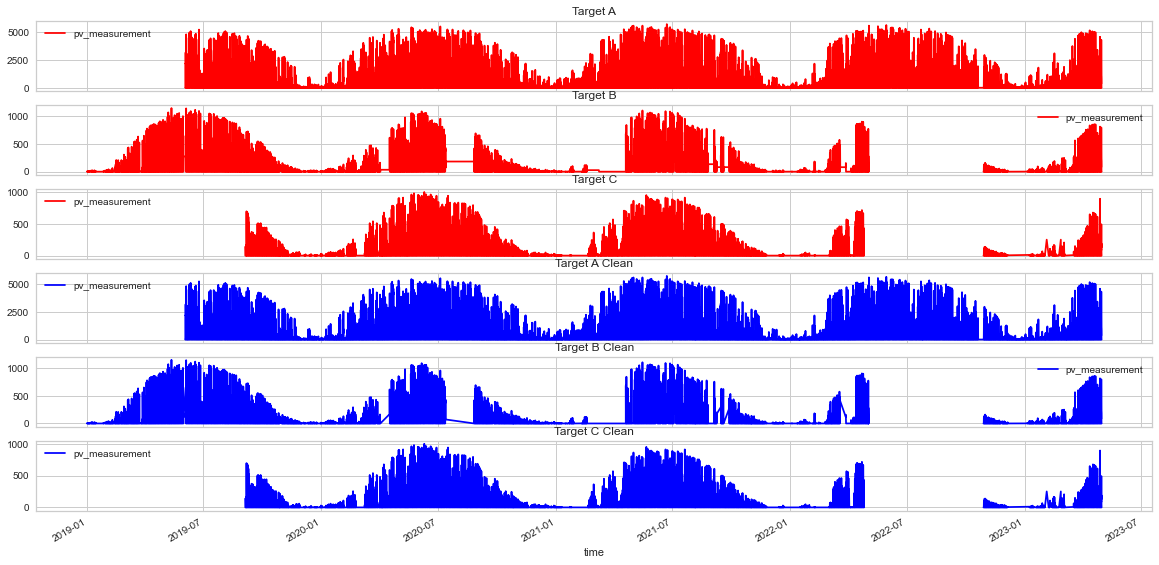

In [40]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



# Data Aggregation

In [41]:
# making shure that target values line up with x_values
import data_func.aggregation as data_agg

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = data_agg.gen_agg(categorical, agg_type=data_agg.stocastic_median, merge_on = 'first')
   mean = data_agg.gen_agg(mean, "mean", merge_on = 'first')

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train



X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])

In [42]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))

x,y:  34060 34060
x,y:  29596 29596
x,y:  26028 26028


In [43]:
# Verifying that all train dataset still have their end data after aggregation in case of allignment issue
for x in X_train:
    print(x["date_forecast"].tail())

34055   2023-04-30 19:00:00
34056   2023-04-30 20:00:00
34057   2023-04-30 21:00:00
34058   2023-04-30 22:00:00
34059   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[ns]
29591   2023-04-30 19:00:00
29592   2023-04-30 20:00:00
29593   2023-04-30 21:00:00
29594   2023-04-30 22:00:00
29595   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[ns]
26023   2023-04-30 19:00:00
26024   2023-04-30 20:00:00
26025   2023-04-30 21:00:00
26026   2023-04-30 22:00:00
26027   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[ns]


# Feature engineering

In [44]:
import data_func.timeseasonality as DTS
import data_func.one_hot_encoding as OHE
import data_func.date_forecast as DTF

columns_to_drop = ['snow_density:kgm3', 'elevation:m', 'snow_drift:idx', 'date_forecast']

for i in range(len(X_train)):
    X_train[i] = DTS.append_seasonal_columns(X_train[i])
    X_train[i] = DTF.date_forecast_columns(X_train[i])

for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    X_frames_test[i] = DTF.date_forecast_columns(X_frames_test[i])

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA
# import data_func.one_hot_encoding as OHE

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
     temp = train.append(test, ignore_index = True)
     index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
     return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
     X_train[i] = OHE.one_hot_encode(X_train[i],OH_columns)
     X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], OH_columns)
     X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
     X_train[i].drop(columns=columns_to_drop, inplace=True)
     X_frames_test[i].drop(columns=columns_to_drop, inplace=True)

def combine_features(df, listOfFeaturesToCombine):
    for features in listOfFeaturesToCombine:
        new_col_name = features[0] + '_mean'
        df[new_col_name] = df[features].mean(axis=1)
        #df.drop(columns=features, inplace=True)
    return df

listOfFeaturesToCombine = [['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'],
                            ["diffuse_rad:W", "direct_rad:W"], 
                           ["diffuse_rad_1h:J", "direct_rad_1h:J"],
                    ]
for i in range(len(X_train)):
    X_train[i] = combine_features(X_train[i], listOfFeaturesToCombine)
    X_frames_test[i] = combine_features(X_frames_test[i], listOfFeaturesToCombine)


## Data Cleaning

In [45]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]

,A,B,C
ceiling_height_agl:m,6126,4588,5122
cloud_base_agl:m,2362,2025,2199


In [46]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]

,A,B,C
ceiling_height_agl:m,188,180,202
cloud_base_agl:m,70,65,88
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720
precip_type_5min:idx_5,720,720,720


In [47]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 20000, "cloud_base_agl:m": 20000}

for i in range(len(X_train)):
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)

# Training the model

In [48]:
# import data_func.combine_all_frames as CAF

# X_train_pd = CAF.combine_all_frames(X_train)
# X_train_pd = OHE.one_hot_encode(X_train_pd, ["location"])

# X_frames_test_pd = CAF.combine_all_frames(X_frames_test)
# X_frames_test_pd = OHE.one_hot_encode(X_frames_test_pd, ["location"])

# Y_frames_train_pd = pd.concat(Y_train, ignore_index=True)

for i in range(len(X_train)):
  X_train[i] = pd.merge(X_train[i], Y_train[i], left_index=True, right_index=True)

# print(X_train[0].columns)
# print(X_train[0].head())

setup_a = RegressionExperiment()
setup_b = RegressionExperiment()
setup_c = RegressionExperiment()

setup_a.setup(X_train[0], target = 'pv_measurement', session_id = 123)
setup_b.setup(X_train[1], target = 'pv_measurement', session_id = 123)
setup_c.setup(X_train[2], target = 'pv_measurement', session_id = 123)



,Description,Value
0,Session id,123
1,Target,pv_measurement
2,Target type,Regression
3,Original data shape,"(34060, 60)"
4,Transformed data shape,"(34060, 60)"
5,Transformed train set shape,"(23842, 60)"
6,Transformed test set shape,"(10218, 60)"
7,Numeric features,59
8,Preprocess,True
9,Imputation type,simple


,Description,Value
0,Session id,123
1,Target,pv_measurement
2,Target type,Regression
3,Original data shape,"(29596, 60)"
4,Transformed data shape,"(29596, 60)"
5,Transformed train set shape,"(20717, 60)"
6,Transformed test set shape,"(8879, 60)"
7,Numeric features,59
8,Preprocess,True
9,Imputation type,simple


,Description,Value
0,Session id,123
1,Target,pv_measurement
2,Target type,Regression
3,Original data shape,"(26028, 60)"
4,Transformed data shape,"(26028, 60)"
5,Transformed train set shape,"(18219, 60)"
6,Transformed test set shape,"(7809, 60)"
7,Numeric features,59
8,Preprocess,True
9,Imputation type,simple


# Make predictions

In [49]:
best_a = setup_a.compare_models()
best_b = setup_b.compare_models()
best_c = setup_c.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,24.4514,3551.1438,59.5378,0.9137,0.8616,1.1353,4.8540
et,Extra Trees Regressor,24.4065,3761.8472,61.2743,0.9086,0.7976,1.0529,6.3190
xgboost,Extreme Gradient Boosting,25.2495,3830.2326,61.8373,0.9069,0.9753,1.1122,1.6150
rf,Random Forest Regressor,25.4488,4091.4911,63.8728,0.9007,0.8115,1.0842,15.4590
gbr,Gradient Boosting Regressor,29.8135,4721.2333,68.6424,0.8853,1.2747,1.4308,6.7870
ridge,Ridge Regression,42.2336,6558.5198,80.9137,0.8407,2.1286,2.9487,0.1410
lr,Linear Regression,42.2907,6565.7710,80.9592,0.8405,2.1312,2.9479,0.0990
br,Bayesian Ridge,42.0424,6586.9634,81.0880,0.8400,2.1154,3.0038,0.1220
lasso,Lasso Regression,41.4810,6628.3948,81.3407,0.8390,2.0759,2.8134,1.1480
en,Elastic Net,41.7753,6681.8233,81.6680,0.8377,2.1009,2.8223,0.9230


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,19.6765,2311.3586,48.0156,0.9153,0.8352,0.5585,1.9550
et,Extra Trees Regressor,19.6310,2462.9901,49.5820,0.9099,0.7370,0.5741,3.9620
xgboost,Extreme Gradient Boosting,20.5545,2531.6382,50.2079,0.9075,0.9269,0.5656,0.6940
rf,Random Forest Regressor,20.2030,2553.7799,50.4907,0.9066,0.7553,0.6007,14.2250
gbr,Gradient Boosting Regressor,22.8993,2772.5475,52.6019,0.8985,1.1427,0.6537,5.2350
lr,Linear Regression,32.3119,3805.1631,61.6560,0.8608,1.9975,1.0096,0.0980
ridge,Ridge Regression,32.1755,3810.7733,61.6997,0.8606,1.9840,1.0156,0.1270
br,Bayesian Ridge,32.0083,3831.5941,61.8684,0.8598,1.9666,1.0100,0.1280
lasso,Lasso Regression,31.3682,3889.1851,62.3335,0.8577,1.8968,0.9976,1.0240
en,Elastic Net,31.5643,3931.1312,62.6703,0.8562,1.8985,1.0256,1.7600


# Evaluate prediction

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

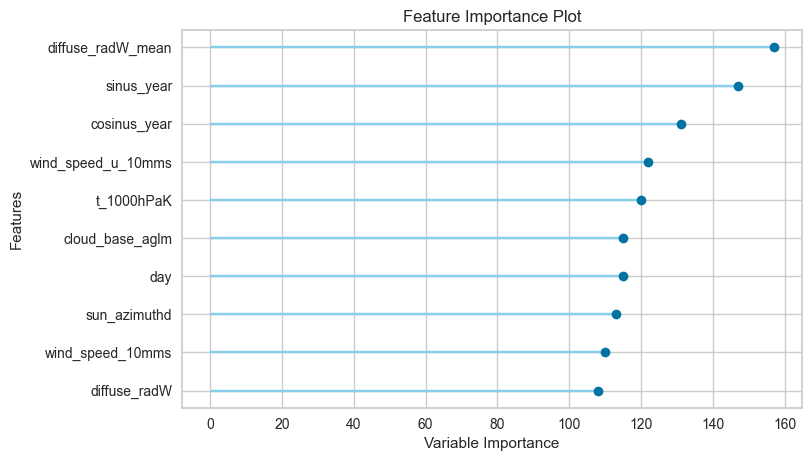

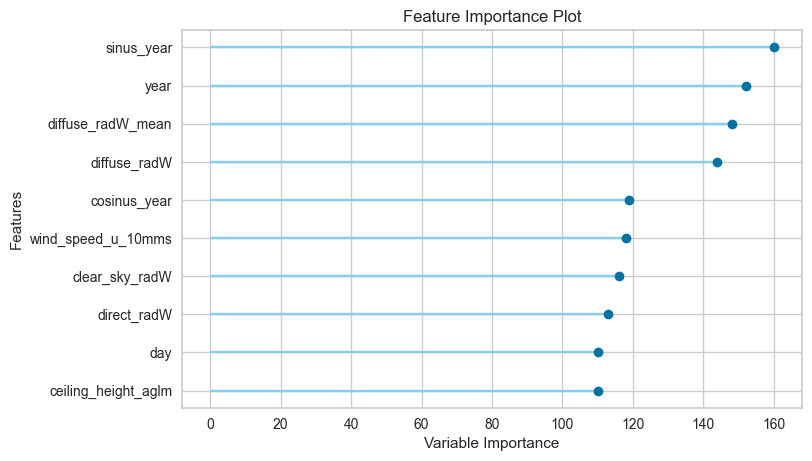

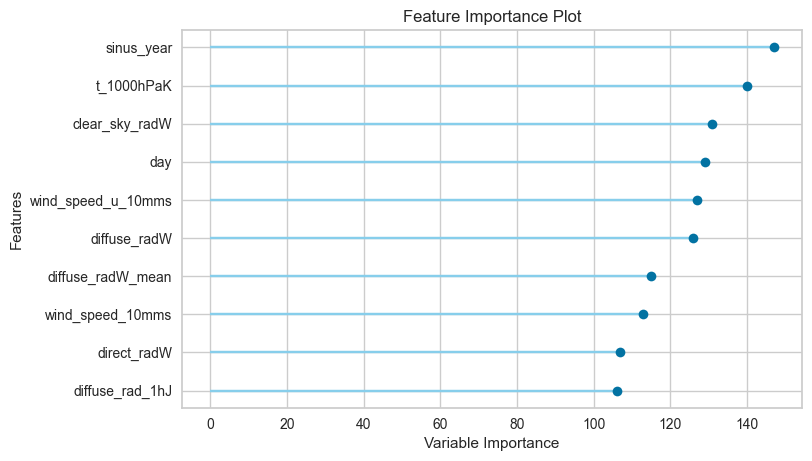

In [50]:
setup_a.evaluate_model(best_a)
setup_b.evaluate_model(best_b)
setup_c.evaluate_model(best_c)

setup_a.plot_model(best_a, plot = 'feature')
setup_b.plot_model(best_b, plot = 'feature')
setup_c.plot_model(best_c, plot = 'feature')

In [51]:
predict_a = setup_a.predict_model(best_a, data=X_frames_test[0])
predict_b = setup_b.predict_model(best_b, data=X_frames_test[1])
predict_c = setup_c.predict_model(best_c, data=X_frames_test[2])

predict_a.head()

,is_day:idx,is_in_shadow:idx,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_point_2m:K,diffuse_rad:W,...,dew_or_rime:idx_1,precip_type_5min:idx_0,precip_type_5min:idx_1,precip_type_5min:idx_2,precip_type_5min:idx_3,precip_type_5min:idx_5,msl_pressure:hPa_mean,diffuse_rad:W_mean,diffuse_rad_1h:J_mean,prediction_label
34060,0,1,4.325,1.28675,912.700012,0.000000,0.000,1061.550049,271.650024,0.000000,...,0,1,0,0.0,0.0,0.0,1008.531250,0.000000,0.000000,1.616220
34061,0,1,4.275,1.28600,1482.099976,0.000000,0.000,1075.100098,271.450012,0.000000,...,0,1,0,0.0,0.0,0.0,1008.025024,0.000000,0.000000,2.309925
34062,0,1,4.150,1.28375,1791.300049,0.000000,0.000,1200.400024,271.049988,0.000000,...,0,1,0,0.0,0.0,0.0,1007.506287,0.000000,0.000000,1.533220
34063,1,0,4.025,1.28200,2312.875000,10124.424805,11.675,1179.849976,270.649994,9.375000,...,0,1,0,0.0,0.0,0.0,1006.974976,5.737500,10305.288086,58.889788
34064,1,0,3.900,1.28100,2198.299805,141748.593750,76.875,920.049988,270.375000,47.400002,...,0,1,0,0.0,0.0,0.0,1006.518738,36.425003,75890.453125,376.019023


In [57]:
y_pred = pd.concat([predict_a['prediction_label'], predict_b['prediction_label'], predict_c['prediction_label']], axis=0, ignore_index=True)
# y_pred = predict_a['prediction_label']
print(y_pred)
for i in range(len(y_pred)):
    if y_pred[i] < 10: 
        y_pred[i] = 0
print(y_pred)


0         1.616220
1         2.309925
2         1.533220
3        58.889788
4       376.019023
           ...    
2155     43.683356
2156     12.954552
2157      2.081204
2158      1.336170
2159      1.336170
Name: prediction_label, Length: 2160, dtype: float64
0         0.000000
1         0.000000
2         0.000000
3        58.889788
4       376.019023
           ...    
2155     43.683356
2156     12.954552
2157      0.000000
2158      0.000000
2159      0.000000
Name: prediction_label, Length: 2160, dtype: float64


# Create submission

In [ ]:
y_test_pred = y_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/submission_pyc.csv', index=False)